In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics

%matplotlib inline

//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Pre-Task: Describe the goals of your study

To determine what factors played an effect into the survival of the passengers on the titanic.

## DATA DICTIONARY

|Title|Description|Type|
|------|------|-------|
|PassengerId|ID of passenger|integer|
|Survived|Survival of passenger (0 = No; 1 = Yes)|integer|
|Pclass|Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)|integer|
|Name|Name of passenger|string|
|Sex|Sex of passenger|string|
|Age|Age of passenger|float|
|SibSp|Number of Siblings/Spouses Aboard|integer|
|Parch|Number of Parents/Children Aboard|integer|
|Ticket|Ticket Number|string|
|Fare|Passenger fare|float|
|Cabin|Cabin|string|
|Embarked|Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)|string|

## Part 1: Aquire the Data

In [4]:
# psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
# password: gastudents

#### 1. Connect to the remote database

In [5]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import connection

In [6]:
engine = create_engine(connection.params)
pd.read_sql("SELECT * FROM pg_catalog.pg_tables WHERE schemaname='public'", con=engine)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers
0,public,train,dsi,None,True,False,False
1,public,table1,dsi_student,None,True,False,False


In [127]:
sql = """
SELECT * FROM train
LIMIT 3
"""

pd.read_sql(sql, con=engine)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


#### 2. Query the database and aggregate the data

In [8]:
# How many people in each Pclass

sql = """
SELECT "Pclass", Count("Pclass") FROM train
GROUP BY "Pclass"
"""

pclass_cnt = pd.read_sql(sql, con=engine)
pclass_cnt

,Pclass,count
0,1,216
1,2,184
2,3,491


In [9]:
# How many male and females

sql = """
SELECT "Sex", Count("Sex") FROM train
GROUP BY "Sex"
"""

sex_cnt = pd.read_sql(sql, con=engine)
sex_cnt

,Sex,count
0,male,577
1,female,314


In [10]:
# How many people embarked from each port

sql = """
SELECT "Embarked", COUNT("Embarked") FROM train
GROUP BY "Embarked"
"""

port_cnt = pd.read_sql(sql, con=engine)
port_cnt

,Embarked,count
0,Q,77
1,None,0
2,S,644
3,C,168


In [11]:
# Survival rate of males and females

sql = """
SELECT "Sex", "Survived", COUNT("Survived") AS Cnt_Surv
FROM train
GROUP BY "Sex", "Survived"
ORDER BY "Sex"
"""

surv_rate = pd.read_sql(sql, con=engine)
surv_rate

,Sex,Survived,cnt_surv
0,female,1,233
1,female,0,81
2,male,0,468
3,male,1,109


In [12]:
# sql = """
# SELECT "Age", COUNT("Sex") AS ct_sex, "Sex"
# From train
# GROUP BY "Sex", "Age"
# ORDER BY "Age" DESC
# """
# pd.read_sql(sql, con=engine)
## Result is 124 missing Age

In [13]:
# change table into dataframe

sql = """
SELECT * FROM train
"""

df = pd.read_sql(sql, con=engine)

#### 5. What are the risks and assumptions of our data? 

The risk is potentially miscounting or not accounting for all the survivors. An assumption you can make is that records were pure and not tampered with, but there is not guarantee it was. For this situation we can make that assumption.

## Part 2: Exploratory Data Analysis

#### 1. Describe the Data

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
index          891 non-null int64
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [15]:
df.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [16]:
df.Age.unique()

array([ 22.  ,  38.  ,  26.  ,  35.  ,    nan,  54.  ,   2.  ,  27.  ,
        14.  ,   4.  ,  58.  ,  20.  ,  39.  ,  55.  ,  31.  ,  34.  ,
        15.  ,  28.  ,   8.  ,  19.  ,  40.  ,  66.  ,  42.  ,  21.  ,
        18.  ,   3.  ,   7.  ,  49.  ,  29.  ,  65.  ,  28.5 ,   5.  ,
        11.  ,  45.  ,  17.  ,  32.  ,  16.  ,  25.  ,   0.83,  30.  ,
        33.  ,  23.  ,  24.  ,  46.  ,  59.  ,  71.  ,  37.  ,  47.  ,
        14.5 ,  70.5 ,  32.5 ,  12.  ,   9.  ,  36.5 ,  51.  ,  55.5 ,
        40.5 ,  44.  ,   1.  ,  61.  ,  56.  ,  50.  ,  36.  ,  45.5 ,
        20.5 ,  62.  ,  41.  ,  52.  ,  63.  ,  23.5 ,   0.92,  43.  ,
        60.  ,  10.  ,  64.  ,  13.  ,  48.  ,   0.75,  53.  ,  57.  ,
        80.  ,  70.  ,  24.5 ,   6.  ,   0.67,  30.5 ,   0.42,  34.5 ,  74.  ])

In [17]:
# Copy the data to keep in original form
data = df.copy()

In [18]:
# change NaN to 0 in Cabin and Embarked

data.Cabin.fillna(0, inplace=True)
data.Embarked.fillna(0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
index          891 non-null int64
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [19]:
# drop NaN in Age
data.dropna(axis=0, how='any', subset=['Age'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
index          714 non-null int64
PassengerId    714 non-null int64
Survived       714 non-null int64
Pclass         714 non-null int64
Name           714 non-null object
Sex            714 non-null object
Age            714 non-null float64
SibSp          714 non-null int64
Parch          714 non-null int64
Ticket         714 non-null object
Fare           714 non-null float64
Cabin          714 non-null object
Embarked       714 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 78.1+ KB


#### 2. Visualize the Data

In [20]:
import seaborn as sns

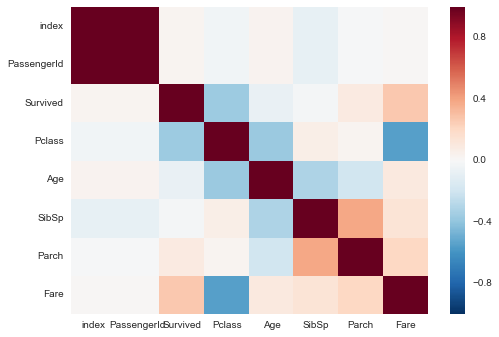

In [21]:
sns.heatmap(data.corr())

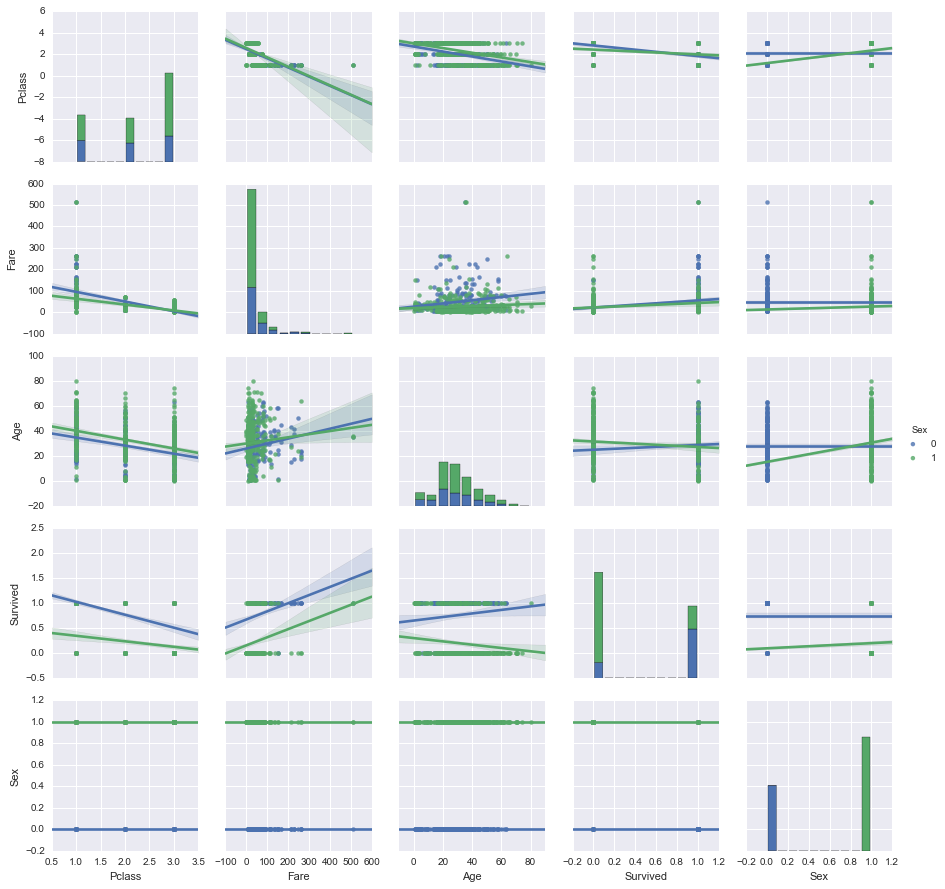

In [143]:
sns.pairplot(data=data, hue='Sex', 
             vars=['Pclass','Fare','Age','Survived','Sex'],
            kind='reg')

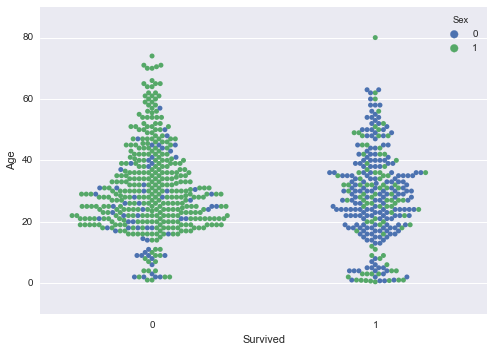

In [139]:
sns.swarmplot(x='Survived',y='Age',hue='Sex',data=data)

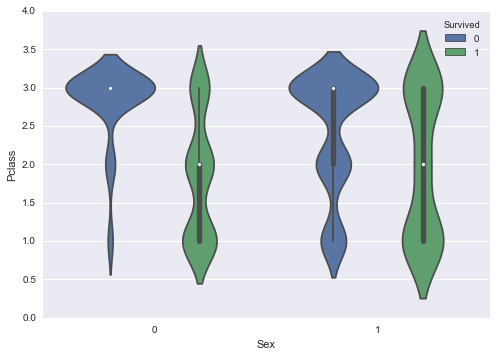

In [199]:
sns.violinplot(x='Sex',y='Pclass',hue='Survived',data=data)

## Part 3: Data Wrangling

#### 1. Create Dummy Variables for *Sex* 

In [26]:
# change male =  1, female = 2
data['Sex'] = data['Sex'].map(lambda x: 1 if x == 'male' else 0)

## Part 4: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

In [27]:
predictors = data[['Sex','Age','Pclass','Fare']]
X = predictors
Y = data['Survived'].values

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

In [37]:
Y = np.ravel(Y)

#### 3. Conduct the logistic regression

In [38]:
lr = LogisticRegression()
lr.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
lr.score(X, Y)

0.79411764705882348

#### 4. Examine the coefficients to see our correlations

In [40]:
lr.coef_

array([[-2.27164301, -0.02546796, -0.9493806 ,  0.00301798]])

#### 6. Test the Model by introducing a *Test* or *Validaton* set 

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
lr.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 7. Predict the class labels for the *Test* set

In [42]:
Y_pred = lr.predict(X_test)
Y_pred

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0])

#### 8. Predict the class probabilities for the *Test* set

In [214]:
Y_pred2 = lr.predict_proba(X_test)
Y_pred2

array([[ 0.47063181,  0.52936819],
       [ 0.19895076,  0.80104924],
       [ 0.26949916,  0.73050084],
       [ 0.79787152,  0.20212848],
       [ 0.55585779,  0.44414221],
       [ 0.89534262,  0.10465738],
       [ 0.7667482 ,  0.2332518 ],
       [ 0.70930143,  0.29069857],
       [ 0.74828532,  0.25171468],
       [ 0.63580694,  0.36419306],
       [ 0.87363283,  0.12636717],
       [ 0.46891551,  0.53108449],
       [ 0.34690448,  0.65309552],
       [ 0.90128485,  0.09871515],
       [ 0.74180414,  0.25819586],
       [ 0.40679449,  0.59320551],
       [ 0.787734  ,  0.212266  ],
       [ 0.32393907,  0.67606093],
       [ 0.44591569,  0.55408431],
       [ 0.80805413,  0.19194587],
       [ 0.86930235,  0.13069765],
       [ 0.33495652,  0.66504348],
       [ 0.20669949,  0.79330051],
       [ 0.88993065,  0.11006935],
       [ 0.89158015,  0.10841985],
       [ 0.32393907,  0.67606093],
       [ 0.09174348,  0.90825652],
       [ 0.67034762,  0.32965238],
       [ 0.5292889 ,

#### 9. Evaluate the *Test* set

#### 10. Cross validate the test set

In [44]:
scores = cross_val_score(lr, X_test, Y_test, cv=5)
print scores
print np.mean(scores)

[ 0.79069767  0.72093023  0.8372093   0.69767442  0.86046512]
0.781395348837


#### 11. Check the Classification Report

In [35]:
from sklearn.metrics import classification_report

In [53]:
print classification_report(Y_test, Y_pred, target_names=['Died','Survived'])

             precision    recall  f1-score   support

       Died       0.82      0.86      0.84       125
   Survived       0.79      0.73      0.76        90

avg / total       0.80      0.80      0.80       215



#### 12. What do the classification metrics tell us?

Precision: how well the model is in assigning passengers in the right category

Recall: how accurate is the model in calculating survivors

f1-score: mean of precision and recall

Support: number of classifcations in that category

#### 13. Check the Confusion Matrix

In [54]:
from sklearn.metrics import confusion_matrix

In [59]:
confusion_matrix(Y_test, Y_pred)

array([[107,  18],
       [ 24,  66]])

#### 14. What does the Confusion Matrix tell us? 

Shows the likelyhood of classification of the passenger.

#### 15. Plot the ROC curve

In [70]:
from sklearn.metrics import roc_curve
roc = roc_curve(Y_test,Y_pred)
roc

(array([ 0.   ,  0.144,  1.   ]),
 array([ 0.        ,  0.73333333,  1.        ]),
 array([2, 1, 0]))

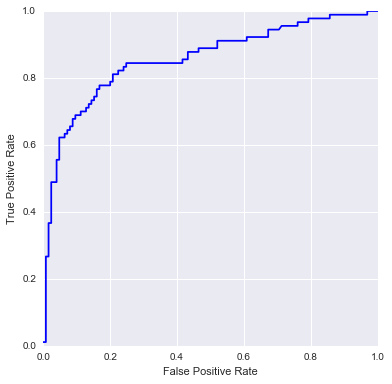

In [226]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred2[:, 1]) # Create ROC curve from probability generated from log reg

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr)) # Make dataframe for reference


plt.figure(figsize=(6,6))
plt.plot(df.fpr, # Set X-axis as false positive rate
         df.tpr, # Set Y-axis as true positive rate 
         'b-')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

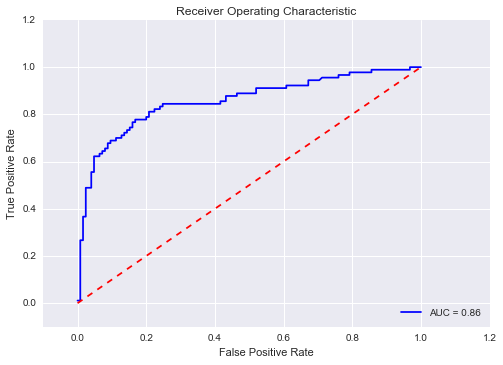

In [220]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred2[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 16. What does the ROC curve tell us?

The ROC tells us the relationship between the True Positive Rate and False Positive Rate at a particular threshold. 

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

In [79]:
from sklearn.grid_search import GridSearchCV

In [80]:
logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}

In [87]:
clf = GridSearchCV(lr, logreg_parameters, cv=5)

In [100]:
clf.fit(X, Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...6e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

In [101]:
print "Best params:", clf.best_params_
print "Score:", clf.best_score_

Best params: {'penalty': 'l1', 'C': 0.59636233165946362, 'solver': 'liblinear'}
Score: 0.791316526611


#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

L1 (Lasso) penalties select the most optimal variables while L2 (Ridge) keeps variables and tries to reduce coefficients to zero.

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

Lasso is good when you have a large amount of variables and want to remove the non related ones. Ridge is good to when the coefficients are high and you want to reduce them to zero in order to lower noise in the model.

#### 5. [BONUS] Explain how the regularization strength (C) modifies the regression loss function. Why do the Ridge and Lasso penalties have their respective effects on the coefficients?

#### 6.a. [BONUS] You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

In [105]:
from sklearn.neighbors import KNeighborsClassifier

In [109]:
knn = KNeighborsClassifier()

In [187]:
knn_params = {
    'n_neighbors':  [5,10,15,20,25,50], 
    'weights':      ("uniform", "distance"),
    'algorithm':    ("ball_tree", "kd_tree", "brute", "auto"),
    'p':            [1,2]
}

In [188]:
clf2 = GridSearchCV(knn, knn_params, cv=5)
clf2.fit(X, Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 10, 15, 20, 25, 50], 'weights': ('uniform', 'distance'), 'algorithm': ('ball_tree', 'kd_tree', 'brute', 'auto'), 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

In [189]:
print "Best params:", clf2.best_params_
print "Score:", clf2.best_score_

Best params: {'n_neighbors': 25, 'weights': 'uniform', 'algorithm': 'ball_tree', 'p': 2}
Score: 0.711484593838


#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### [BONUS] Why?

More neighbors increase bias and less neighbors increases variance.

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

Logistic regression you would want to use when variables are continuous and KNN is best when variables are categorical.

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

In [192]:
knn2 = KNeighborsClassifier(n_neighbors= 25, weights='uniform', algorithm='ball_tree', p= 2)

In [193]:
knn2.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=25, p=2,
           weights='uniform')

In [194]:
knn2_pred = knn2.predict(X_test)
knn2_pred

array([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1])

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

In [195]:
confusion_matrix(Y_test, knn2_pred)

array([[98, 27],
       [44, 46]])

#### 7. [BONUS] Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

## Part 7: [BONUS] Precision-recall

#### 1. Gridsearch the same parameters for logistic regression but change the scoring function to 'average_precision'

`'average_precision'` will optimize parameters for area under the precision-recall curve instead of for accuracy.

In [196]:
logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}
clf4 = GridSearchCV(lr, logreg_parameters, scoring='average_precision', cv=5)
clf4.fit(X, Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...6e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=0)

#### 2. Examine the best parameters and score. Are they different than the logistic regression gridsearch in part 5?

In [197]:
print "Best params:", clf4.best_params_
print "Score:", clf4.best_score_

Best params: {'penalty': 'l1', 'C': 7.5431200633546069, 'solver': 'liblinear'}
Score: 0.821866331626


#### 3. Create the confusion matrix. Is it different than when you optimized for the accuracy? If so, why would this be?

#### 4. Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

[See the sklearn plotting example here.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

## Part 8: [VERY BONUS] Decision trees, ensembles, bagging

#### 1. Gridsearch a decision tree classifier model on the data, searching for optimal depth. Create a new decision tree model with the optimal parameters.

#### 2. Compare the performace of the decision tree model to the logistic regression and kNN models.

#### 3. Plot all three optimized models' ROC curves on the same plot. 

#### 4. Use sklearn's BaggingClassifier with the base estimator your optimized decision tree model. How does the performance compare to the single decision tree classifier?

#### 5. Gridsearch the optimal n_estimators, max_samples, and max_features for the bagging classifier.

#### 6. Create a bagging classifier model with the optimal parameters and compare it's performance to the other two models.